# Introduction to supervised sentiment analysis

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2016 term"

## Contents

0. [Overview](#Overview)
0. [Set-up](#Set-up)
0. [Data readers](#Data-readers)
0. [Feature functions](#Feature-functions)
0. [Modeling the labels](#Modeling-the-labels)
0. [Building datasets for experiments](#Building-datasets-for-experiments)
0. [Basic optimization](#Basic-optimization)
0. [Experiments](#Experiments)
0. [Hyperparameter search](#Hyperparameter-search)
0. [Statistical comparison of classifier models](#Statistical-comparison-of-classifier-models)
0. [Distributed representations as features](#Distributed-representations-as-features)
0. [Additional sentiment resources](#Additional-sentiment-resources)
0. [ In-class exploration](#In-class-exploration)
0. [In-class bake-off](#In-class-bake-off)
0. [Homework 2](#Homework-2)

## Overview

The goal of this notebook is to provide a basic introduction to supervised learning in the context of a problem that has long been central to academic research and industry applications: __sentiment analysis__. 

The notebook is built around the [Stanford Sentiment Treebank](http://nlp.stanford.edu/sentiment/) (SST), a widely-used resource for evaluating supervised NLU models, and one that provides rich linguistic representations.

If you're relatively new to supervised learning, we suggest you study the details of this notebook closely and follow the links to additional resources. If you're familiar with supervied learning, then you can focus right away on innovative feature representations and modeling. As of this writing, the state-of-the-art for the SST seems to be around 88% accuracy for the binary problem and 48% accuracy for the five-class problem. Perhaps you can best these numbers!

Sentiment analysis seems simple at first but turns out to exhibit all of the complexity of full natural language understanding. To see this, consider how your intuitions about the sentiment of the following sentences can change depending on perspective, social relationships, tone of voice, and other aspects of the context of utterance:

* There was an earthquake in LA.
* The team failed the physical challenge. (We win/lose!)
* They said it would be great. They were right/wrong.
* Many consider the masterpiece bewildering, boring, slow-moving or annoying.
* The party fat-cats are sipping their expensive, imported wines.
* Oh, you’re terrible!

SST mostly steers around these challenges by including only focused, evaluative texts (sentences from movie reviews), but you should have them in mind if you consider new domains and applications for the ideas.

## Set-up

0. Make sure your environment includes all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u).
0. Download [the train/dev/test Stanford Sentiment Treebank distribution](http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip), unzip it, and put the resulting folder in the same directory as this notebook. (If you want to put it somewhere else, change `sst_home` below.)
0. Download [the Wikipedia 2014 + Gigaword 5 distribution](http://nlp.stanford.edu/data/glove.6B.zip) of the pretrained GloVe vectors, unzip it, and put the resulting folder in the the same directory as this notebook. (If you want to put it somewhere else, change `glove_home` below.)

In [2]:
sst_home = 'trees'
glove_home = 'glove.6B'

In [3]:
import os
import codecs
import random
import unicodecsv
from collections import Counter
import numpy as np
from scipy.sparse import csr_matrix
from nltk.tree import Tree
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
import scipy.stats
import utils

## Data readers

The train/dev/test SST distribution contains files that are lists of trees where the part-of-speech tags have been replaced with sentiment scores `0...4`, where `0` and `1` are negative labels, `2` is a neutral label, and `3` and `4` are positive labels. Our readers yield `(tree, label)` pairs, where `tree` is an [NLTK Tree instance](http://www.nltk.org/_modules/nltk/tree.html) and `score` is a string.

In [4]:
def sentiment_treebank_reader(src_filename, include_subtrees=False, replace_root_score=True):
    """Iterator for the Penn-style distribution of the Stanford 
    Sentiment Treebank. The iterator yields (tree, label) pairs. 

    The root node of the tree is the label, so the root node itself is 
    replaced with a string to ensure that it doesn't get used as a 
    predictor. The subtree labels are retained. If they are used, it can 
    feel like cheating (see `root_daughter_scores_phis` below), so take 
    care!
    
    The labels are strings. They do not make sense as a linear order
    because negative ('0', '1'), neutral ('2'), and positive ('3','4')
    do not form a linear order conceptually, and because '0' is 
    stronger than '1' but '4' is stronger than '3'.
    
    Parameters
    ----------
    src_filename : str
        Full path to the file to be read.
    
    include_subtrees : boolean (default: False)
        Whether to yield all the subtrees with labels or just the full 
        tree. In both cases, the label is the root of the subtree.
        
    replace_root_score : boolean (default: True)
        The root node of the tree is the label, so, by default, the root 
        node itself is replaced with a string to ensure that it doesn't 
        get used as a predictor.

    Yields
    ------
    (tree, label)
        nltk.Tree, str in {'0','1','2','3','4'}
    
    """
    for line in codecs.open(src_filename, 'r', 'utf8'):
        tree = Tree.fromstring(line)
        if include_subtrees:
            for subtree in tree.subtrees():
                label = subtree.label()
                if replace_root_score:
                    subtree.set_label("X")
                yield (subtree, label) 
        else:
            label = tree.label()
            if replace_root_score:
                tree.set_label("S")
            yield (tree, label) 

The following are convenience functions for reading `train.txt` and `dev.txt`:

In [5]:
def train_reader():
    """Convenience function for reading the train file, full-trees only."""
    src = os.path.join(sst_home, 'train.txt')
    return sentiment_treebank_reader(src, include_subtrees=False)

def dev_reader():
    """Convenience function for reading the dev file, full-trees only."""
    src = os.path.join(sst_home, 'dev.txt')
    return sentiment_treebank_reader(src, include_subtrees=False)

In SST parlance, the __all-nodes__ task trains and assesses, not just with the full sentence, but also with all the labeled subtrees. The following are convenience readers for such experiments:

In [6]:
def allnodes_train_reader():
    """Convenience function for reading the train file, all nodes."""
    src = os.path.join(sst_home, 'train.txt')
    return sentiment_treebank_reader(src, include_subtrees=True)

def allnodes_dev_reader():
    """Convenience function for reading the dev file, all nodes."""
    src = os.path.join(sst_home, 'dev.txt')
    return sentiment_treebank_reader(src, include_subtrees=True)

__Important notes__: 

* We've deliberately left out `test` readers. We urge you not to use the `test` set until and unless you are running experiments for a final project or similar. Overuse of test-sets corrupts them, since even subtle lessons learned from those runs can be incorporated back into model-building efforts.

* We actually have mixed feelings about the overuse of  `dev` that might result from working with this notebook! We've tried to encourage using just splits of the training data for assessment most of the time, with only occasionally use of `dev`. This will give you a clearer picture of how you will ultimately do on `test`; over-use of `dev` can lead to over-fitting on that particular dataset with a resulting loss of performance of `test`.

The notebook interface is good about displaying the [NLTK Tree objects](http://www.nltk.org/_modules/nltk/tree.html), which is handy for understanding their structure:

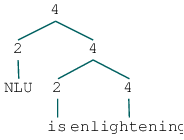

In [7]:
Tree.fromstring("""(4 (2 NLU) (4 (2 is) (4 enlightening)))""")

## Feature functions

Feature representation is arguably the most important step in any machine learning task. As you experiment with the SST, you'll come to appreciate this fact, since your choice of feature function will have a far greater impact on the effectiveness of your models than any other choice you make.

We will define our feature functions as `dict`s mapping feature names (which can be any object that can be a `dict` key) to their values (which must be booleans, ints, or floats). For optimization, we will use `sklearn`'s `DictVectorizer` class to turn these into matrices of features. The `dict`-based approach gives us a lot of flexibility and frees us from having to worry about the underlying feature matrix.

A typical baseline or default feature representation in NLP or NLU is built from unigrams. Here, those are the leaf nodes of the tree:

In [8]:
def unigrams_phi(tree):
    """The basis for a unigrams feature function.
    
    Parameters
    ----------
    tree : nltk.tree
        The tree to represent.
    
    Returns
    -------    
    defaultdict
        A map from strings to their counts in `tree`. (Counter maps a 
        list to a dict of counts of the elements in that list.)
    
    """
    return Counter(tree.leaves())

In the docstring for `sentiment_treebank_reader`, I pointed out that the labels on the subtrees can be used in a way that feels like cheating. Here's the most dramatic instance of this: `root_daughter_scores_phi` uses just the labels on the daughters of the root to predict the root (label). This will result in performance well north of 90% F1, but that's hardly worth reporting. (Interestingly, using the labels on the leaf nodes is much less powerful.) Anyway, don't use this function!

In [9]:
def root_daughter_scores_phi(tree):    
    """The best way we've found to cheat without literally using the 
    labels as part of the feature representations. Don't use this for 
    any real experiments!"""
    return Counter([child.label() for child in tree])

## Modeling the labels

Working with the SST involves making decisions about how to handle the raw SST labels. The interpretation of these labels is as follows ([Socher et al., sec. 3](http://www.aclweb.org/anthology/D/D13/D13-1170.pdf)):

* `'0'`: very negative
* `'1'`: negative
* `'2'`: neutral
* `'3'`: positive
* `'4'`: very positive

The labels look like they could be treated as totally ordered, even continuous. However, conceptually, they do not form such an order. Rather, they consist of three separate classes, with the negative and positive classes being totally ordered:

* `'0' > '1'`: negative
* `'2'`: neutral
* `'4' > '3'`: positive

Thus, in this notebook, we'll look mainly at binary (positive/negative) and ternary tasks.

A related note: the above shows that the __fine-grained sentiment task__ for the SST is particularly punishing as usually formulated, since it ignores the partial-order structure in the categories completely. As a result, mistaking `'0'` for `'1'` is as bad as mistaking `'0'` for `'4'`, though the first error is clearly less severe than the second.

The following functions will be used to define the labels for our experiments:

In [10]:
def binary_class_func(y):
    """Define a binary SST task.
    
    Parameters
    ----------
    y : str
        Assumed to be one of the SST labels.
          
    Returns
    ------- 
    str or None    
        None values are ignored by `build_dataset` and thus left out of 
        the experiments.
    
    """
    if y in ("0", "1"):
        return "negative"
    elif y in ("3", "4"):
        return "positive"
    else:
        return None
    
def ternary_class_func(y):    
    """Define a binary SST task. Just like `binary_class_func` except 
    input '2' returns 'neutral'."""    
    if y in ("0", "1"):
        return "negative"
    elif y in ("3", "4"):
        return "positive"
    else:
        return "neutral"

If you do want to run fine-grained sentiment, just define an identity function over the SST labels.

## Building datasets for experiments

The next phase for our analysis is a kind of set-up phase: we need to use

* a reader like `train_reader`,
* a feature function like `unigrams_phi`, and
* a class function like `binary_class_func`

to build a dataset that can be used for training and assessing a model. The heart of this is `build_dataset`. See its documentation for details on how it works. Much of this is about taking advantage of `sklearn`'s many functions for model building.

In [11]:
def build_dataset(reader, phi, class_func, vectorizer=None):
    """Core general function for building experimental datasets.
    
    Parameters
    ----------
    reader : iterator
       Should be `train_reader`, `dev_reader`, or another function
       defined in those terms. This is the dataset we'll be 
       featurizing.
       
    phi : feature function
       Any function that takes an `nltk.Tree` instance as input 
       and returns a bool/int/float-valued dict as output.
       
    class_func : function on the SST labels
       Any function like `binary_class_func` or `ternary_class_func`. 
       This modifies the SST labels based on the experimental 
       design. If `class_func` returns None for a label, then that 
       item is ignored.
       
    vectorizer : sklearn.feature_extraction.DictVectorizer    
       If this is None, then a new `DictVectorizer` is created and
       used to turn the list of dicts created by `phi` into a 
       feature matrix. This happens when we are training.
              
       If this is not None, then it's assumed to be a `DictVectorizer` 
       and used to transform the list of dicts. This happens in 
       assessment, when we take in new instances and need to 
       featurize them as we did in training.
       
    Returns
    -------
    dict
        A dict with keys 'X' (the feature matrix), 'y' (the list of
        labels), 'vectorizer' (the `DictVectorizer`), and 
        'raw_examples' (the `nltk.Tree` objects, for error analysis).
    
    """    
    labels = []
    feat_dicts = []
    raw_examples = []
    for tree, label in reader():
        cls = class_func(label)
        # None values are ignored -- these are instances we've
        # decided not to include.
        if cls != None:
            labels.append(cls)
            feat_dicts.append(phi(tree))
            raw_examples.append(tree)
    feat_matrix = None
    # In training, we want a new vectorizer:    
    if vectorizer == None:
        vectorizer = DictVectorizer(sparse=True)
        feat_matrix = vectorizer.fit_transform(feat_dicts)
    # In assessment, we featurize using the existing vectorizer:
    else:
        feat_matrix = vectorizer.transform(feat_dicts)
    return {'X': feat_matrix, 
            'y': labels, 
            'vectorizer': vectorizer, 
            'raw_examples': raw_examples}

## Basic optimization

We're now in a position to begin training supervised models!

For the most part, in this course, we will not study the theoretical aspects of machine learning optimization, concentrating instead on how to optimize systems effectively in practice. That is, this isn't a theory course, but rather an experimental, project-oriented one.

Nonetheless, we do want to avoid treating our optimizers as black boxes that work their magic and give us some assessment figures for whatever we feed into them. That seems irresponsible from a scientific and engineering perspective, and it also sends the false signal that the optimization process is inherently mysterious. So we do want to take a minute to demystify it with some simple code.

The following `BasicSGDClassifier` is a complete optimization framework. Well, it's complete in the sense that it achieves our full task of supervised learning. It's incomplete in the sense that it is very basic. You probably wouldn't want to use it in experiments. Rather, we're going to encourage you to rely on `sklearn` for your experiments (see below). Still, this is a good basic picture of what's happening under the hood.


So what is `BasicSGDClassifier` doing? The heart of it is the `fit` function (reflecting the usual `sklearn` naming system). This method implements a hinge-loss stochastic sub-gradient descent optimization. Intuitively, it works as follows:

0. Start by assuming that all the feature weights are `0`.
0. Move through the dataset instance-by-instance in random order.
0. For each instance, classify it using the current weights. 
0. If the classification is incorrect, move the weights in the direction of the correct classification

This process repeats for a user-specified number of iterations (default `10` below), and the weight movement is tempered by a learning-rate parameter `eta` (default `0.1`). The output is a set of weights that can be used to make predictions about new (properly featurized) examples.

In more technical terms, the objective function is 

$$
  \min_{\mathbf{w} \in \mathbb{R}^{d}}
  \sum_{(x,y)\in\mathcal{D}} 
  \max_{y'\in\mathbf{Y}}
  \left[\mathbf{Score}_{\textbf{w}, \phi}(x,y') + \mathbf{cost}(y,y')\right] - \mathbf{Score}_{\textbf{w}, \phi}(x,y)
$$

where $\mathbf{w}$ is the set of weights to be learned, $\mathcal{D}$ is the training set of example&ndash;label pairs, $\mathbf{Y}$ is the set of labels, $\mathbf{cost}(y,y') = 0$ if $y=y'$, else $1$, and $\mathbf{Score}_{\textbf{w}, \phi}(x,y')$ is the inner product of the weights 
$\mathbf{w}$ and the example as featurized according to $\phi$.

The `fit` method is then calculating the sub-gradient of this objective. In succinct pseudo-code:

* Initialize $\mathbf{w} = \mathbf{0}$
* Repeat $T$ times:
    * for each $(x,y)$ in $\mathcal{D}$ (in random order):
        * $\tilde{y} = \text{argmax}_{y'\in \mathcal{Y}} \mathbf{Score}_{\textbf{w}, \phi}(x,y') + \mathbf{cost}(y,y')$
        * $\mathbf{w} =  \mathbf{w} + \eta(\phi(x,y) - \phi(x,\tilde{y}))$
      
We'll use this basic and widely applicable framework throughout the term, to optimize neural networks, structured prediction models, and all sorts of basic classification tasks.

In [12]:
class BasicSGDClassifier:    
    """Basic implementation hinge-loss stochastic sub-gradient descent 
    optimization, intended to illustrate the basic concepts of classifier 
    optimization in code."""
    def __init__(self, iterations=10, eta=0.1):
        """
        Parameters
        ----------
        iterations : int (default: 10)
            Number of training epochs (full runs through shuffled data).
        
        eta : float (default: 0.1)
            Learning rate parameter.
            
        """        
        self.iterations = iterations
        self.eta = eta

    def fit(self, feat_matrix, labels): 
        """Core optimization function.
        
        Parameters
        ----------        
        feat_matrix : 2d matrix (np.array or any scipy.sparse type)
            The design matrix, one row per example. Hence, the row 
            dimensionality is the example count and the column 
            dimensionality is number of features.
            
        labels : list
            The labels for each example, hence assumed to have the
            same length as, and be aligned with, `feat_matrix`.
            
        For attributes, we follow the `sklearn` style of using a 
        final `_` for attributes that are created by `fit` methods: 
            
        Attributes
        ----------
        self.classes_ : list
            The set of class labels in sorted order.
            
        self.n_classes_ : int
            Length of `self.classes_`
            
        self.coef_ : np.array of dimension (class count, feature count)
            These are the weights, named as in `sklearn`. They are 
            organized so that each row represents the feature weights 
            for a given class, as is typical in `sklearn`.
            
        """        
        # We'll deal with the labels via their indices into self.classes_:
        self.classes_ = sorted(set(labels))
        self.n_classes_ = len(self.classes_)
        # Useful dimensions to store:
        examplecount, featcount = feat_matrix.shape
        # The weight matrix -- classes by row:
        self.coef_ = np.zeros((self.n_classes_, featcount))
        # Indices for shuffling the data at the start of each epoch:
        indices = list(range(examplecount))
        for _ in range(self.iterations):
            random.shuffle(indices)
            for i in indices:
                # Training instance as a feature rep and a label index:
                rep = feat_matrix[i]                 
                label_index = self.classes_.index(labels[i])
                # Costs are 1.0 except for the true label:
                costs = np.ones(self.n_classes_)
                costs[label_index] = 0.0
                # Make a prediction:
                predicted_index = self.predict_one(rep, costs=costs)
                # Weight update if it's an incorrect prediction:
                if predicted_index != label_index:
                    self.coef_[label_index] += self.eta * rep                                  
    
    def predict_one(self, rep, costs=0.0):
        """The core prediction function. This is computed as
        
        (rep * self.coef_.T) + costs
        
        which corresponds to taking the inner product of `rep`
        with each row in `self.weights` and adding `costs`.
        
        After that, the code just needs to figure out which
        class is highest scoring and make a random choice 
        from that set (in case of ties).

        Parameters
        ----------
        rep : np.array of dimension featcount or 
              `scipy.sparse` matrix of dimension (1 x `featcount`)
        
        costs : float or np.array of dimension self.classcount
            Where this is 0.0, we're doing prediction. Where it
            is an array, we expect a 0.0 at the coordinate 
            corresponding to the true label and a 1.0 in all 
            other positions.
        
        Returns
        -------
        int
            The index of the correct class. This is for the 
            sake of the `fit` method. `predict` returns the class
            names themselves.
        
        """
        scores = rep.dot(self.coef_.T) + costs
        # Manage the difference between scipy and numpy 1d matrices:
        scores = scores.reshape(self.n_classes_)
        # Set of highest scoring label indices (in case of ties):
        candidates = np.argwhere(scores==np.max(scores)).flatten()    
        return random.choice(candidates)
    
    def predict(self, reps):
        """Batch prediction function for experiments. 
        
        Parameters
        ----------
        reps : list or feature matrix
           A featurized set of examples to make predictions about.
           
        Returns
        -------        
        list of str
            A list of class names -- the predictions. Unlike `predict_one`, 
            it returns the class name rather than its index.
                
        """
        return [self.classes_[self.predict_one(rep)] for rep in reps]

For the sake of our experimental framework, a simple wrapper for the above:

In [13]:
def fit_basic_sgd_classifier(X, y):    
    """Wrapper for `BasicSGDClassifier`.
    
    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.
        
    y : list
        The list of labels for rows in `X`.
    
    Returns
    -------
    BasicSGDClassifier
        A trained `BasicSGDClassifier` instance.
    
    """    
    mod = BasicSGDClassifier()
    mod.fit(X, y)
    return mod

As I said above, we likely don't want to rely on `BasicSGDClassifier` (though it does a good job with SST!). Instead, we want to rely on `sklearn`. Here's a simple wrapper for [sklearn.linear.model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) using our 
`build_dataset` paradigm.

In [14]:
def fit_maxent_classifier(X, y):    
    """Wrapper for `sklearn.linear.model.LogisticRegression`. This is also 
    called a Maximum Entropy (MaxEnt) Classifier, which is more fitting 
    for the multiclass case.
    
    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.
        
    y : list
        The list of labels for rows in `X`.
    
    Returns
    -------
    sklearn.linear.model.LogisticRegression
        A trained `LogisticRegression` instance.
    
    """
    mod = LogisticRegression(fit_intercept=True)
    mod.fit(X, y)
    return mod

## Experiments

We now have all the pieces needed to run experiments. And we're going to want to run a lot of experiments, trying out different feature functions, taking different perspectives on the data and labels, and using different models. To make that process efficient and regimented, we now define a function `experiment`. All it does is pull together these pieces and use them to train and assess. It's complicated, but the flexibility will turn out to be an asset.

In [15]:
def experiment(
        train_reader=train_reader, 
        assess_reader=None, 
        train_size=0.7,
        phi=unigrams_phi, 
        class_func=ternary_class_func,
        train_func=fit_maxent_classifier,
        score_func=utils.safe_macro_f1,
        verbose=True):
    """Generic experimental framework for SST. Either assesses with a 
    random train/test split of `train_reader` or with `assess_reader` if 
    it is given.
    
    Parameters
    ----------
    train_reader : SST iterator (default: `train_reader`)
        Iterator for training data.
       
    assess_reader : iterator or None (default: None)
        If None, then the data from `train_reader` are split into 
        a random train/test split, with the the train percentage 
        determined by `train_size`. If not None, then this should 
        be an iterator for assessment data (e.g., `dev_reader`).
        
    train_size : float (default: 0.7)
        If `assess_reader` is None, then this is the percentage of
        `train_reader` devoted to training. If `assess_reader` is
        not None, then this value is ignored.
       
    phi : feature function (default: `unigrams_phi`)
        Any function that takes an `nltk.Tree` instance as input 
        and returns a bool/int/float-valued dict as output.
       
    class_func : function on the SST labels
        Any function like `binary_class_func` or `ternary_class_func`. 
        This modifies the SST labels based on the experimental 
        design. If `class_func` returns None for a label, then that 
        item is ignored.
       
    train_func : model wrapper (default: `fit_maxent_classifier`)
        Any function that takes a feature matrix and a label list
        as its values and returns a fitted model with a `predict`
        function that operates on feature matrices.
    
    score_metric : function name (default: `utils.safe_macro_f1`)
        This should be an `sklearn.metrics` scoring function. The 
        default is weighted average F1 (macro-averaged F1). For 
        comparison with the SST literature, `accuracy_score` might
        be used instead. For micro-averaged F1, use
        
        (lambda y, y_pred : f1_score(y, y_pred, average='micro', pos_label=None))
                
        For other metrics that can be used here, see
        see http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
        
    verbose : bool (default: True)
        Whether to print out the model assessment to standard output.
        Set to False for statistical testing via repeated runs.
       
    Prints
    -------    
    To standard output, if `verbose=True`
        Model accuracy and a model precision/recall/F1 report. Accuracy is 
        reported because many SST papers report that figure, but the 
        precision/recall/F1 is better given the class imbalances and the 
        fact that performance across the classes can be highly variable.
        
    Returns
    -------
    float
        The overall scoring metric as determined by `score_metric`.
    
    """        
    # Train dataset:
    train = build_dataset(train_reader, phi, class_func, vectorizer=None) 
    # Manage the assessment set-up:
    X_train = train['X']
    y_train = train['y']
    X_assess = None 
    y_assess = None
    if assess_reader == None:
         X_train, X_assess, y_train, y_assess = train_test_split(
                X_train, y_train, train_size=train_size)
    else:
        # Assessment dataset using the training vectorizer:
        assess = build_dataset(
            assess_reader, 
            phi, 
            class_func, 
            vectorizer=train['vectorizer'])
        X_assess, y_assess = assess['X'], assess['y']
    # Train:      
    mod = train_func(X_train, y_train)    
    # Predictions:
    predictions = mod.predict(X_assess)
    # Report:
    if verbose:
        print('Accuracy: %0.03f' % accuracy_score(y_assess, predictions))
        print(classification_report(y_assess, predictions, digits=3))
    # Return the overall score:
    return score_func(y_assess, predictions)    

Here's an experiment with all default values:

In [16]:
_ = experiment()

Accuracy: 0.601
             precision    recall  f1-score   support

   negative      0.600     0.687     0.641       997
    neutral      0.318     0.130     0.184       516
   positive      0.650     0.750     0.696      1051

avg / total      0.564     0.601     0.572      2564



Here's a run on the dev set (use sparingly!):

In [17]:
_ = experiment(assess_reader=dev_reader)

Accuracy: 0.602
             precision    recall  f1-score   support

   negative      0.628     0.689     0.657       428
    neutral      0.343     0.153     0.211       229
   positive      0.629     0.750     0.684       444

avg / total      0.569     0.602     0.575      1101



Let's see how our reference optimizer does on the same task:

In [18]:
_ = experiment(train_func=fit_basic_sgd_classifier)

Accuracy: 0.586
             precision    recall  f1-score   support

   negative      0.606     0.693     0.647      1051
    neutral      0.269     0.203     0.231       478
   positive      0.677     0.655     0.666      1035

avg / total      0.572     0.586     0.577      2564



Where does our default set-up sit with regard to published baselines for the binary problem? (Compare  [Socher et al., Table 1](http://www.aclweb.org/anthology/D/D13/D13-1170.pdf).)

In [19]:
_ = experiment(class_func=binary_class_func)

Accuracy: 0.769
             precision    recall  f1-score   support

   negative      0.784     0.731     0.757      1020
   positive      0.756     0.806     0.780      1056

avg / total      0.770     0.769     0.769      2076



## Hyperparameter search

The training process learns a set of parameters &mdash; the weights. There are typically lots of other parameters that need to be set. For instance, our `BasicSGDClassifier` has a learning rate parameter and a training iteration parameter. These are called __hyperparameters__. The more powerful `sklearn` classifiers often have many more such hyperparameters. These are outside of the explicitly stated objective, hence the "hyper" part. 

So far, we have just set the hyperparameters by hand. However, their optimal values can vary widely between datasets, and choices here can dramatically impact performance, so we would like to set them as part of the overall experimental framework.

Luckily, `sklearn` provides a lot of functionality for setting hyperparameters via cross-validation. The following function implements a basic framework for taking advantage of these options. This method has the same basic shape as `fit_maxent_classifier` above: it takes a dataset as input and returns a trained model. However, to find its favored model, it explores a space of hyperparameters supplied by the user, seeking the optimal combination of settings.

__Note__: this kind of search seems not to have a large impact for SST as we're using it. However, it can matter a lot for other data sets, and it's also an important step to take when trying to publish, since reviewers are likely to want to check that your comparisons aren't based in part on opportunistic or ill-considered choices for the hyperparameters.

In [20]:
def fit_classifier_with_crossvalidation(X, y, basemod, cv, param_grid, scoring='f1_macro'): 
    """Fit a classifier with hyperparmaters set via cross-validation.

    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.
        
    y : list
        The list of labels for rows in `X`.  
    
    basemod : an sklearn model class instance
        This is the basic model-type we'll be optimizing.
    
    cv : int
        Number of cross-validation folds.
        
    param_grid : dict
        A dict whose keys name appropriate parameters for `basemod` and 
        whose values are lists of values to try.
        
    scoring : value to optimize for (default: f1_macro)
        Other options include 'accuracy' and 'f1_micro'. See
        http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            
    Prints
    ------
    To standard output:
        The best parameters found.
        The best macro F1 score obtained.
        
    Returns
    -------
    An instance of the same class as `basemod`.
        A trained model instance, the best model found.
        
    """    
    # Find the best model within param_grid:
    crossvalidator = GridSearchCV(basemod, param_grid, cv=cv, scoring=scoring)
    crossvalidator.fit(X, y)
    # Report some information:
    print("Best params", crossvalidator.best_params_)
    print("Best score: %0.03f" % crossvalidator.best_score_)
    # Return the best model found:
    return crossvalidator.best_estimator_

Here's a fairly full-featured use of the above for the MaxEnt model family:

In [21]:
def fit_maxent_with_crossvalidation(X, y):
    """A MaxEnt model of dataset with hyperparameter 
    cross-validation. Some notes:
        
    * 'fit_intercept': whether to include the class bias feature.
    * 'C': weight for the regularization term (smaller is more regularized).
    * 'penalty': type of regularization -- roughly, 'l1' ecourages small 
      sparse models, and 'l2' encourages the weights to conform to a 
      gaussian prior distribution.
    
    Other arguments can be cross-validated; see 
    http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    
    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.
        
    y : list
        The list of labels for rows in `X`.   
    
    Returns
    -------
    sklearn.linear_model.LogisticRegression
        A trained model instance, the best model found.
    
    """    
    basemod = LogisticRegression()
    cv = 5
    param_grid = {'fit_intercept': [True, False], 
                  'C': [0.4, 0.6, 0.8, 1.0, 2.0, 3.0],
                  'penalty': ['l1','l2']}    
    return fit_classifier_with_crossvalidation(X, y, basemod, cv, param_grid)

An example run:

In [22]:
_ = experiment(
        train_func=fit_maxent_with_crossvalidation, 
        class_func=binary_class_func)

Best params {'C': 2.0, 'penalty': 'l2', 'fit_intercept': False}
Best score: 0.768
Accuracy: 0.770
             precision    recall  f1-score   support

   negative      0.767     0.743     0.755       987
   positive      0.773     0.795     0.784      1089

avg / total      0.770     0.770     0.770      2076



So there's no real change for this basic experiment. Still, I'm glad to have checked. For real experiments, I would likely explore a much larger space of parameters. The small size of SST makes this feasible, so why not!

## Statistical comparison of classifier models

Suppose two classifiers differ according to an effectiveness measure like F1 or accuracy. Are they meaningfully different?

For very large datasets, the answer might be clear: if performance is very stable across different train/assess splits and the difference in terms of correct predictions has practical import, then you can clearly say yes. 

With smaller datasets, or models whose performance is closer together, it can be harder to determine whether the two models are different. We can address this question in a basic way with repeated runs and basic null-hypothesis testing on the resulting score vectors.

The following is a basic function for doing such testing. The default set-up uses the non-parametric [Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) to make the comparisons.

In [23]:
def compare_models(
        stats_test=scipy.stats.wilcoxon,
        trials=10,
        phi1=unigrams_phi,
        phi2=None,
        train_func1=fit_maxent_classifier,         
        train_func2=None,
        reader=train_reader, 
        train_size=0.7, 
        class_func=ternary_class_func, 
        score_func=utils.safe_macro_f1):    
    """Wrapper for comparing models. The parameters are like those of 
    `experiment`, with the same defaults, except
    
    Parameters
    ----------    
    stats_test : scipy.stats function
        Defaults to `scipy.stats.wilcoxon`, a non-parametric version 
        of the paired t-test. 
        
    trials : int (default: 10)
        Number of runs on random train/test splits of `reader`,
        with `train_size` controlling the amount of training data.
            
    train_func1, train_func2
        Just like `train_func` for `experiment`. `train_func1`
        defaults to `fit_maxent_classifier`. If `train_func2`
        is None, then it is set equal to `train_func`.
        
    phi1, phi2
        Just like `phi` for `experiment`. `phi1` defaults to 
        `unigrams_phi`. If `phi2` is None, then it is set equal 
        to `phi1`.
        
    Prints
    ------
    To standard output
        A report of the assessment.
        
    Returns
    -------
    (np.array, np.array, float)
        The first two are the scores from each model (length `trials`),
        and the third is the p-value returned by stats_test.
        
    TODO
    ----
    This function can easily be parallelized. The ParallelPython
    makes this easy:http://www.parallelpython.com
    
    """    
    if phi2 == None:
        phi2 = phi1
    if train_func2 == None:
        train_func2 = train_func1    
    scores1 = np.array([experiment(train_reader=reader, 
        phi=phi1,
        train_func=train_func1,
        class_func=class_func,
        score_func=score_func,
        verbose=False) for _ in range(trials)])    
    scores2 = np.array([experiment(train_reader=reader,
        phi=phi2,
        train_func=train_func2,
        class_func=class_func,
        score_func=score_func,
        verbose=False) for _ in range(trials)])
    # stats_test returns (test_statistic, p-value). We keep just the p-value:
    pval = stats_test(scores1, scores2)[1]
    # Report:
    print('Model 1 mean: %0.03f' % scores1.mean())
    print('Model 2 mean: %0.03f' % scores2.mean())
    print('p = %0.03f' % pval if pval >= 0.001 else 'p < 0.001')
    # Return the scores for later analysis, and the p value:
    return (scores1, scores2, pval)

Here's a comparison of our SGD classifier with `sklearn`'s MaxEnt classifier, using `unigrams_phi` to featurize:

In [24]:
_ = compare_models(
        train_func1=fit_basic_sgd_classifier, 
        train_func2=fit_maxent_classifier)

Model 1 mean: 0.510
Model 2 mean: 0.510
p = 0.959


## Distributed representations as features

The goal of this final content section is to make connections between our study of distributed representations and supervised learning. 

Arguably, more than any specific model architecture, this is the major innovation of __deep learning__: rather than designing feature functions by hand, we use dense, distributed representations, often derived from unsupervised models.

To illustrate this process, we'll use GloVe vectors. The approach is very simple; problem 4 encourages you to trying more advanced, creative approaches. 

To start, we need a simple GloVe reader. The one in `utils` just creates a mapping from strings to their GloVe vectors. Here we use the `100d` version, but the others are worth trying:

In [25]:
GLOVE = utils.glove2dict(os.path.join(glove_home, 'glove.6B.100d.txt'))

Now that we have the GloVe data, the only additional code we need to write is a new feature function that makes use of it. The feature function  `glove_leaves_phi` does the most basic reasonable thing: it gets GloVe vectors for all the words it can and just sums them into a single vector.

__Note__: because we want to use the above framework, we have to take the step of turning each vector into a dict with nonce key names. This is silly because it all just gets turned back into a vector by `build_dataset`, but the costs are small in practice.

In [26]:
def glove_leaves_phi(tree, np_func=np.sum):
    """Represent tree as a combination of the GloVe vector of its words.
    
    Parameters
    ----------
    tree : nltk.Tree
    
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that 
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a 
        fixed length, no matter what the size of the tree is.
    
    Returns
    -------
    dict 
        A map from column index names to GloVe values. (The dict
        structure is for the sake of conforming to our general 
        framework for feature functions.) 
    
    """    
    allvecs = np.array([GLOVE[w] for w in tree.leaves() if w in GLOVE])
    feats = {}    
    if len(allvecs) > 0:
        combo = np_func(allvecs, axis=0)
        names = list(range(len(combo)))
        feats = dict(zip(names, combo))        
    return feats

Performance of this basic approach on the binary problem, using our default training function:

In [27]:
_ = experiment(phi=glove_leaves_phi, class_func=binary_class_func)

Accuracy: 0.756
             precision    recall  f1-score   support

   negative      0.734     0.741     0.737       960
   positive      0.775     0.769     0.772      1116

avg / total      0.756     0.756     0.756      2076



## Additional sentiment resources

Here are a few publicly available datasets and other resources; if you decide to work on sentiment analysis, get in touch with the teaching staff &mdash; we have a number of other resources that we can point you to.

* Sentiment lexica: http://sentiment.christopherpotts.net/lexicons.html
* NLTK now has a SentiWordNet module: http://www.nltk.org/api/nltk.corpus.reader.html#module-nltk.corpus.reader.sentiwordnet
* Stanford Large Movie Review Dataset: http://ai.stanford.edu/~amaas/data/sentiment/index.html
* SemEval-2013: Sentiment Analysis in Twitter: https://www.cs.york.ac.uk/semeval-2013/task2/
* Starter code for a sentiment-aware tokenizer: http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py

## In-class exploration

In order to get a feel for the codebase and prepare for the in-class bake-off, we'll use class time for the following:

0. Write a new feature function. We recommend starting with something simple.
0. Use `experiment` to evaluate your new feature function on the binary and ternary versons of SST, with at least `fit_basic_sgd_classifier` and `fit_maxent_classifier`.
0. If you have time, compare your feature function with `unigrams_phi` using `compare_models`.

__Submit__: At the end of class, bring a summary of your feature function (e.g., "bigrams") to one of the teaching team. We'll summarize the approaches taken in the class discussion forum.

## In-class bake-off

The goal of the in-class bake-off is to achieve the highest average F1 score on the development set as reported by `experiment`, with the ternary class function. 

The only restriction: the feature functions cannot make any use of the subtree labels.

Here's the baseline model:

In [28]:
_ = experiment(
        train_reader=train_reader,         # Fixed by the competition.
        assess_reader=dev_reader,          # Fixed.
        class_func=ternary_class_func,     # Fixed.
        train_func=fit_maxent_classifier,  # Free to write your own!
        phi=unigrams_phi)                  # Free to write your own!

Accuracy: 0.602
             precision    recall  f1-score   support

   negative      0.628     0.689     0.657       428
    neutral      0.343     0.153     0.211       229
   positive      0.629     0.750     0.684       444

avg / total      0.569     0.602     0.575      1101



So the baseline is 0.575. For the top scores (bake-off winners), we'll want to see the function call and any new code (especially feature functions). At the end of class, bring your score to one of the teaching team. We'll report the results in the class discussion forum.

## Homework 2

### 1. Error analysis [3 points]

Error analysis is one of the most important methods for steadily improving a system, as it facilitates a kind of human-powered hill-climbing on your ultimate objective. Often, it takes a careful human analyst just a few examples to spot a major pattern that can lead to a beneficial change to the feature representations.

__Your task__: improve `experiment` above by adding a keyword argument `view_errors` with default value `0`. Where the  value is `n`, the function prints out a random selection of `n` errors: the underlying tree, the correct label, and the predicted label.

__Note__: the error printing need only work where `assess_reader` is specified (not None). If no `assess_reader` is given, then you can just change `view_errors=0`. (I realized that printing errors for random train/test splits requires more code-rewriting than I originally anticipated. It's doable but a bit cumbersome.)

### 2. Reproducing Socher et al.'s NaiveBayes baselines [4 points]

[Socher et al.](http://www.aclweb.org/anthology/D/D13/D13-1170.pdf) compare against two NaiveBayes baselines: one with unigram features and one with bigram features. See how close you can come to reproducing the performance of those models on the binary, root-only problem (values in the rightmost column of their Table 1, rows 1 and 3). 

__Specific tasks__:

0. Write a bigrams feature function on the model of `unigrams_phi`.
0. Write a function `fit_nb_classifier` that serves as a wrapper for [sklearn.naive_bayes.MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).
0. Use `experiment` to run the experiments, assessing against `dev_reader`.
0. Use `compare_models` to compare the feature_functions statistically with `fit_nb_classifier` as the shared `train_func` value.

Submit all the code you write for this, including any new `import` statements, as well as the output from running the code in steps 3 and 4.

__A note on performance__: in our experience, the unigrams NaiveBayes model achieves about 0.79, and the bigrams NaiveBayes model under-performs, at around 0.75. It's fine to submit answers with comparable numbers; the Socher et al. baselines are very strong.

### 3. Sentiment shifters [3 points]

Some words have greater power than others to shift sentiment around. Because the SST has sentiment labels on all of its subconstituents, it provides an opportunity to study these shifts in detail. This question takes a first step in that direction by asking you to identify some of these sentiment shifters automatically.

More specifically, the task is to identify words that effect a particularly large shift between the value of their sibling node and the value of their mother node. For instance, in the tree

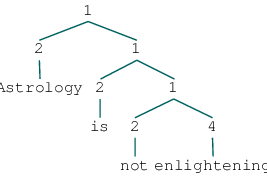

In [29]:
t = Tree.fromstring("""(1 (2 Astrology) (1 (2 is) (1 (2 not) (4 enlightening))))""")
t

we have the shifter scores:

* _not_: `1-4=-3`
* _enlightening_: `1-2=-1`
* _is_: `1-1=0`
* _Astrology_: `1-1=0`.

__Your task__: write a function that calculates the mean shifter scores for all the words in the training data and prints out the top 10 and bottom 10 as ranked by those mean scores, _limiting attention to words with at least 100 scores to reduce noise_. 

__Tips__:

* You'll probably want to use `tree.subtrees()` to inspect all of the subtrees in each `tree`.
* `len(tree)` counts the number of children (immediate descendents) of `tree`.
* Use `from six import string_types` and then `isinstance(subtree[0][0], string_types)` will test whether the left daughter of `subtree` has a lexical child.
* `tree.label()` gives the label for any tree or subtree.
* Your reader should use `replace_root_score=False` so that you keep the root node label.

### Extra credit: Toward compositional distributed features [up to 2 points]

In [Distributed representations as features](#Distributed-representations-as-features), we just averaged together all of the leaf-node GloVe vectors to obtain a fixed-dimensional representation for all sentences. This ignores all of the tree structure. See if you can do better by paying attention to the binary tree structure.

__Your tasks__:
0. Write a function `glove_subtree_phi` that obtains a vector representation for each subtree by combining the vectors of its daughters, with the leaf nodes again given by GloVe (any dimension you like) and the full representation of the sentence given by the final vector obtained by this recursive process. You can decide on how you combine the vectors. As usual, the requirement is just that we get representations of the same dimensionality for all trees (a basic requirement of supervised learning in our sense). Submit this function.
0. Use `experiment` to evaluate this on the binary-class, root-only problem, with `fit_maxent_with_crossvalidation` as the training function. Use `dev_reader` for the evaluation. Submit the code for this function call as well. 